In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import col
import json


import pandas as pd
import numpy as np
import matplotlib

In [2]:

spark = SparkSession.builder.appName("Proyecto-Big-Data").getOrCreate()
spark.sparkContext.setLogLevel("WARN")

ps: unrecognized option: p
BusyBox v1.30.1 (2019-10-26 11:23:07 UTC) multi-call binary.

Usage: ps [-o COL1,COL2=HEADER]

Show list of processes

	-o COL1,COL2=HEADER	Select columns for display
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/07/29 19:28:52 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
/usr/lib/python3.7/site-packages/pyspark/context.py:317: FutureWarning: Python 3.7 support is deprecated in Spark 3.4.
  warnings.warn("Python 3.7 support is deprecated in Spark 3.4.", FutureWarning)


## Dataset
El dataset que estamos usando esta importado de un json, cargamos ambos datasets

In [3]:

def cargar_y_preprocesar_json(ruta_archivo):
    """Carga archivos JSON con estructura no estándar y realiza preprocesamiento básico"""
    with open(ruta_archivo, 'r') as f:
        datos = json.load(f)
    
    # Extraer metadatos y registros
    campos = datos['fields']
    registros = datos['records']
    
    # Mapear tipos de datos
    mapeo_tipos = {
        "int": IntegerType(),
        "text": StringType()
    }
    
    # Crear esquema dinámico
    esquema = StructType([
        StructField(campo['id'], mapeo_tipos.get(campo['type'], StringType()), nullable=True)
        for campo in campos
    ])
    
    # Crear DataFrame
    rdd = spark.sparkContext.parallelize(registros)
    df = spark.createDataFrame(rdd, esquema)
    
    # Convertir tipos de datos
    for campo in campos:
        tipo_spark = mapeo_tipos.get(campo['type'], StringType())
        df = df.withColumn(campo['id'], col(campo['id']).cast(tipo_spark))
    
    return df

# Cargar datasets
df_comida = cargar_y_preprocesar_json("comida.json")
df_desempleo = cargar_y_preprocesar_json("desempleo.json")

# Limpieza adicional común
for df in [df_comida, df_desempleo]:
    df = df.dropDuplicates()  # Eliminar duplicados
    df = df.na.fill("Desconocido")  # Tratar valores nulos

# Mostrar resultados
print("Esquema Comida:")
df_comida.printSchema()

print("\nEsquema Desempleo:")
df_desempleo.printSchema()

print(f"\nRegistros Comida: {df_comida.count()}")
print(f"Registros Desempleo: {df_desempleo.count()}")

FileNotFoundError: [Errno 2] No such file or directory: 'comida.json'

In [4]:
# Download latest version
path = kagglehub.dataset_download("mathchi/diabetes-data-set")

print("Path to dataset files:", path)

100%|██████████████████████████████████████████████████████████████████████████████| 8.91k/8.91k [00:00<00:00, 5.46MB/s]

Extracting model files...
Path to dataset files: /root/.cache/kagglehub/datasets/mathchi/diabetes-data-set/versions/1


## Aclaración sobre uso de pandas en las próximas celdas
Luego de haberlo descargado, usamos pandas para revisar que el archivo se descargó correctamente y, posteriormente, para mostrar el método `.head()` del dataframe de Pandas y ver sus valores. A partir de ahí, después de mostrar el método `.info()` para saber los tipos que necesita el Schema en Spark, ya se trabaja con dataframes de Spark y la sesión de spark.

In [5]:
diabetes_df = pd.read_csv(path + "/diabetes.csv")
diabetes_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [6]:
# Hay que definirle el Schema
diabetes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


# Cargado y Limpieza de archivo de entrada CSV

In [7]:
diabetes_schema = StructType([StructField('Pregnancies', IntegerType()),
                           StructField('Glucose', IntegerType()),
                           StructField('BloodPressure', IntegerType()),
                           StructField('SkinThickness', IntegerType()),
                           StructField('Insulin', IntegerType()),
                           StructField('BMI', FloatType()),
                           StructField('DiabetesPedigreeFunction', FloatType()),
                           StructField('Age', IntegerType()),
                           StructField('Outcome', IntegerType())])

In [8]:
diabetes_df = spark.read.csv(path + "/diabetes.csv", schema=diabetes_schema, header=True)
diabetes_df.show()

+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|          6|    148|           72|           35|      0|33.6|                   0.627| 50|      1|
|          1|     85|           66|           29|      0|26.6|                   0.351| 31|      0|
|          8|    183|           64|            0|      0|23.3|                   0.672| 32|      1|
|          1|     89|           66|           23|     94|28.1|                   0.167| 21|      0|
|          0|    137|           40|           35|    168|43.1|                   2.288| 33|      1|
|          5|    116|           74|            0|      0|25.6|                   0.201| 30|      0|
|          3|     78|           50|           32|     88|31.0|                   0.248| 26|      1|


# Gráficos y estadísticas descriptivas

In [9]:
diabetes_df.summary().show()

25/07/28 03:10:18 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+------------------+-----------------+------------------+------------------+------------------+-----------------+------------------------+------------------+------------------+
|summary|       Pregnancies|          Glucose|     BloodPressure|     SkinThickness|           Insulin|              BMI|DiabetesPedigreeFunction|               Age|           Outcome|
+-------+------------------+-----------------+------------------+------------------+------------------+-----------------+------------------------+------------------+------------------+
|  count|               768|              768|               768|               768|               768|              768|                     768|               768|               768|
|   mean|3.8450520833333335|     120.89453125|       69.10546875|20.536458333333332| 79.79947916666667|31.99257813890775|      0.4718763029280429|33.240885416666664|0.3489583333333333|
| stddev|  3.36957806269887|31.97261819513622|19.355807170644777|15.9522175

Con el cuadro anterior podemos ver valores intercuartílicos, pero para verlo mejor, se graficarán boxplots.
Algo que desde ya llama la atención es que hay valores atípicos en medidas fisiológicas que no tiene sentido, por ejemplo, que la glucosa, presión arterial, insulina y el IMC tengan valores en 0, lo que puede indicar es que para personas que no se tomó esa medida, se colocó un 0.

## Boxplots y otros gráficos

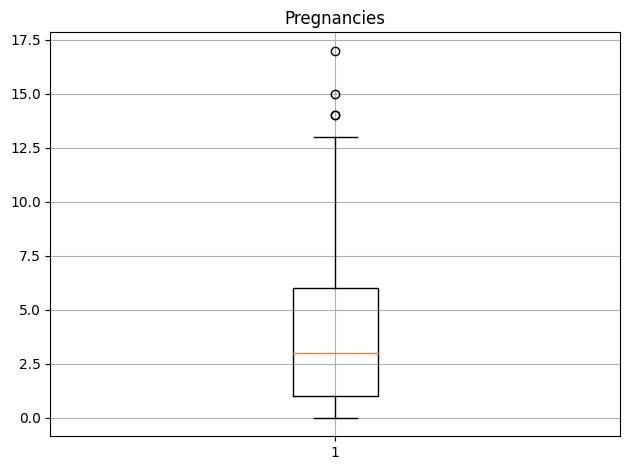

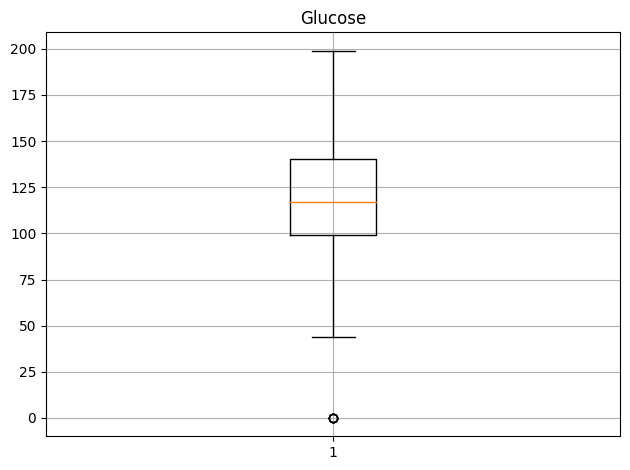

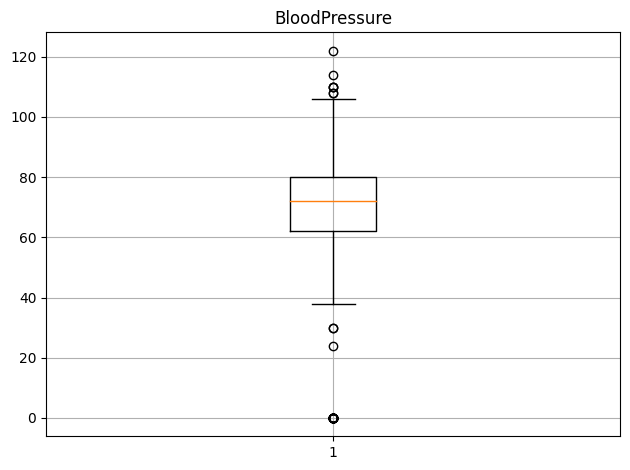

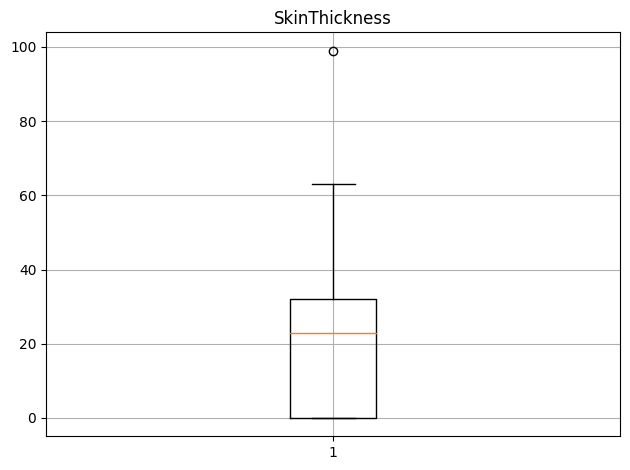

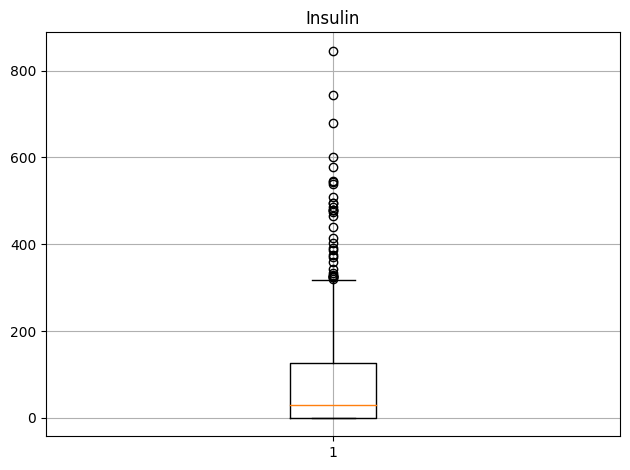

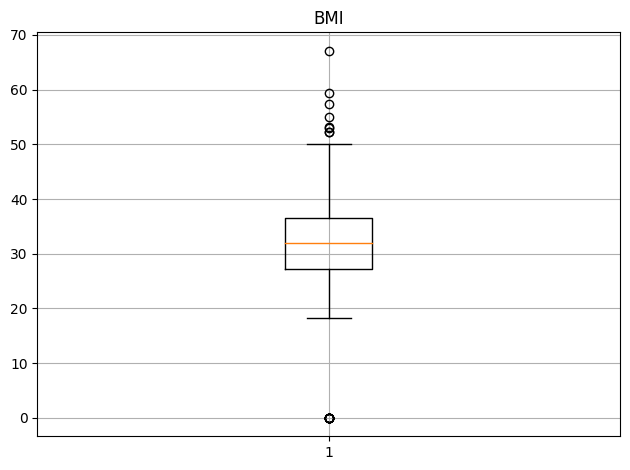

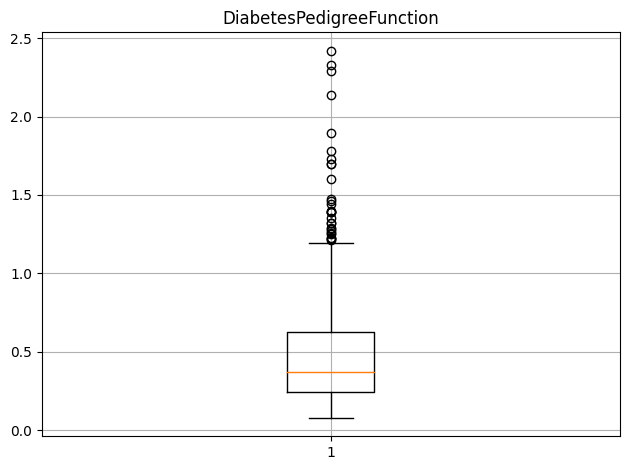

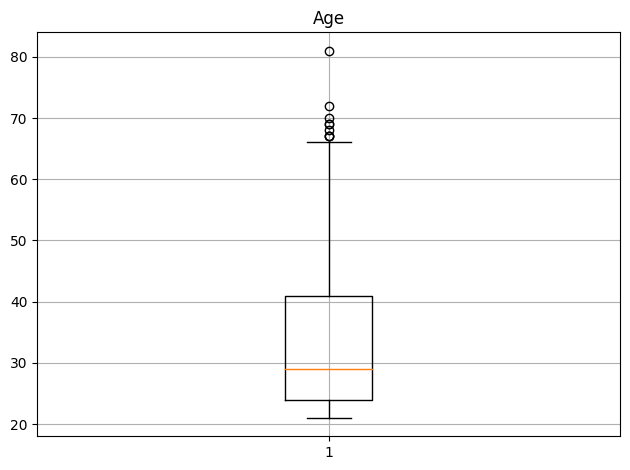

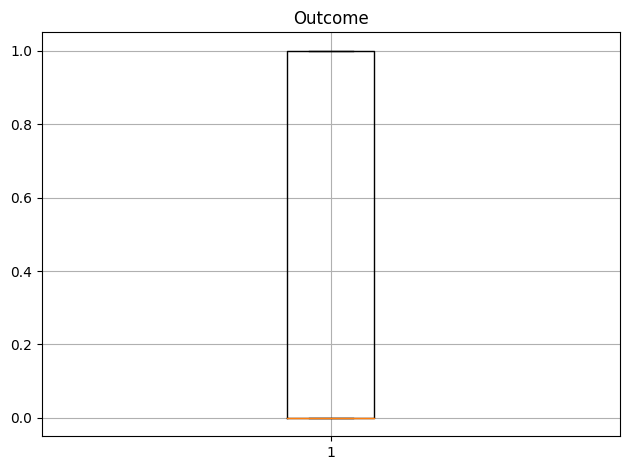

In [10]:
import matplotlib.pyplot as plt

cols = ["Pregnancies", "Glucose", "BloodPressure", "SkinThickness",
        "Insulin", "BMI", "DiabetesPedigreeFunction", "Age", "Outcome"]
datos = [[] for _ in cols]

for fila in diabetes_df.collect():
    for i, col in enumerate(cols):
        datos[i].append(fila[col])

for feature_data, feature_name in zip(datos, cols):
    plt.figure()
    plt.boxplot(feature_data)
    plt.title(feature_name)
    plt.grid(True)
    plt.tight_layout()
    plt.show()  # Show each plot separately


Se ve que hay variables en las que los _outliers_ pueden aportar contexto al no estar muy lejos de los IQRs, pero otras en las que definitivamente hay valores muy extremos.

In [11]:
columns_to_clean = ["Glucose", "BMI", "SkinThickness", "BloodPressure"]

iqr_bounds = {}
for col in columns_to_clean:
    q1, q3 = diabetes_df.approxQuantile(col, [0.25, 0.75], 0.01)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    iqr_bounds[col] = (lower_bound, upper_bound)


from pyspark.sql.functions import col


filtered_df = diabetes_df

for col_name, (low, high) in iqr_bounds.items():
    filtered_df = filtered_df.filter((col(col_name) >= low) & (col(col_name) <= high))

## Vectorización y matriz de correlación

In [12]:
# Para realizar operaciones más detalladas es necesario expresar las filas originales en vectores
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=["Pregnancies", "Glucose", "BloodPressure", "SkinThickness",
               "Insulin", "BMI", "DiabetesPedigreeFunction", "Age"],
    outputCol='features')

vector_df = assembler.transform(filtered_df)
vector_df = vector_df.select(['features', 'Outcome'])
vector_df.show()

+--------------------+-------+
|            features|Outcome|
+--------------------+-------+
|[6.0,148.0,72.0,3...|      1|
|[1.0,85.0,66.0,29...|      0|
|[8.0,183.0,64.0,0...|      1|
|[1.0,89.0,66.0,23...|      0|
|[0.0,137.0,40.0,3...|      1|
|[5.0,116.0,74.0,0...|      0|
|[3.0,78.0,50.0,32...|      1|
|[2.0,197.0,70.0,4...|      1|
|[4.0,110.0,92.0,0...|      0|
|[10.0,168.0,74.0,...|      1|
|[10.0,139.0,80.0,...|      0|
|[1.0,189.0,60.0,2...|      1|
|[5.0,166.0,72.0,1...|      1|
|[0.0,118.0,84.0,4...|      1|
|[7.0,107.0,74.0,0...|      1|
|[1.0,115.0,70.0,3...|      1|
|[3.0,126.0,88.0,4...|      0|
|[8.0,99.0,84.0,0....|      0|
|[7.0,196.0,90.0,0...|      1|
|[9.0,119.0,80.0,3...|      1|
+--------------------+-------+
only showing top 20 rows



25/07/28 03:10:27 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


<AxesSubplot:>

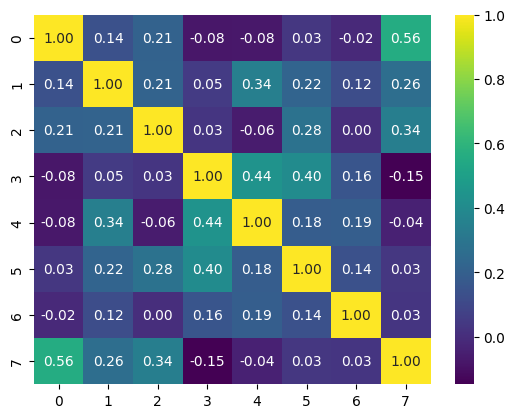

In [13]:
from pyspark.ml.stat import Correlation
import seaborn as sns
import matplotlib.pyplot as plt

pearson_matrix = Correlation.corr(vector_df, 'features').collect()[0][0]

sns.heatmap(pearson_matrix.toArray(), annot=True, fmt=".2f", cmap='viridis')

In [14]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.sql import SparkSession

standard_scaler = StandardScaler(inputCol="features",outputCol="scaled_features",)

scale_model = standard_scaler.fit(vector_df)

scaled_df = scale_model.transform(vector_df)

scaled_df.show()


+--------------------+-------+--------------------+
|            features|Outcome|     scaled_features|
+--------------------+-------+--------------------+
|[6.0,148.0,72.0,3...|      1|[1.78756034833938...|
|[1.0,85.0,66.0,29...|      0|[0.29792672472323...|
|[8.0,183.0,64.0,0...|      1|[2.38341379778584...|
|[1.0,89.0,66.0,23...|      0|[0.29792672472323...|
|[0.0,137.0,40.0,3...|      1|[0.0,4.4876637610...|
|[5.0,116.0,74.0,0...|      0|[1.48963362361615...|
|[3.0,78.0,50.0,32...|      1|[0.89378017416969...|
|[2.0,197.0,70.0,4...|      1|[0.59585344944646...|
|[4.0,110.0,92.0,0...|      0|[1.19170689889292...|
|[10.0,168.0,74.0,...|      1|[2.97926724723230...|
|[10.0,139.0,80.0,...|      0|[2.97926724723230...|
|[1.0,189.0,60.0,2...|      1|[0.29792672472323...|
|[5.0,166.0,72.0,1...|      1|[1.48963362361615...|
|[0.0,118.0,84.0,4...|      1|[0.0,3.8652870350...|
|[7.0,107.0,74.0,0...|      1|[2.08548707306261...|
|[1.0,115.0,70.0,3...|      1|[0.29792672472323...|
|[3.0,126.0,

In [15]:
from pyspark.ml.functions import vector_to_array

scaled_df = scaled_df.withColumn("scaled_array", vector_to_array("scaled_features"))

feature_cols = ["Pregnancies", "Glucose", "BloodPressure", "SkinThickness","Insulin", "BMI", "DiabetesPedigreeFunction", "Age"]

for i, col_name in enumerate(feature_cols):
    scaled_df = scaled_df.withColumn(
        f"{col_name}_scaled",
        col("scaled_array")[i]
    )
    
# (columnas individuales)
final_df = scaled_df.select(
    *[f"{col}_scaled" for col in feature_cols],
    "Outcome"
)

#  quitar sufijo “_scaled”
for col_name in feature_cols:
    final_df = final_df.withColumnRenamed(f"{col_name}_scaled", col_name)

final_df.write \
    .format("jdbc") \
    .mode("overwrite") \
    .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
    .option("user", "postgres") \
    .option("password", "pword") \
    .option("dbtable", "scaledData") \
    .save()


test_df = spark.read \
  .format("jdbc") \
  .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
  .option("user", "postgres") \
  .option("password", "pword") \
  .option("dbtable", "scaledData") \
  .load()

print("Filas en scaledData:", test_df.count())
test_df.show(5)



Filas en scaledData: 708
+------------------+------------------+------------------+------------------+------------------+-----------------+------------------------+------------------+-------+
|       Pregnancies|           Glucose|     BloodPressure|     SkinThickness|           Insulin|              BMI|DiabetesPedigreeFunction|               Age|Outcome|
+------------------+------------------+------------------+------------------+------------------+-----------------+------------------------+------------------+-------+
| 1.787560348339381|4.8479871287573255|6.3097322299253795|2.2829583771646025|               0.0|5.235238252639466|      1.9212497183087591| 4.268985670551658|      1|
|0.2979267247232302|2.7843169320565724| 5.783921210764931|1.8915940839363847|               0.0|  4.1445638643273|      1.0755322167325527|2.6467711157420277|      0|
|2.3834137977858414| 5.994470571368855| 5.608650871044782|               0.0|               0.0|3.630388477138778|       2.059138510874525|2

En la celda de arriba simplemente estamos guardando los datos ya limpios dentro de la base de datos iterando por cada una de las columnas para asegurarse que se mantengan todos los datos de los features, para verificar que se están guardando correctamente podemos ver las 5 primeras filas.
Posteriormente vamos a importar las bibliotecas necesarias para el entrenamiento del modelo y leer los datos de la base.


# Primer modelo (Random Forest)

In [16]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline

db_url = "jdbc:postgresql://host.docker.internal:5433/postgres"
db_properties = {
    "user": "postgres",
    "password": "pword",
    "driver": "org.postgresql.Driver"
}

df = spark.read.jdbc(
    url=db_url,
    table="scaledData",
    properties=db_properties
)

Elegimos Random Forest porque va muy acorde al tamaño de nuestro dataset que no es muy grande, por lo que es un tiempo de entrenado razonable, incluyendo el hecho de que nos da métricas de suma importancia para identificar que factores influyen más en la predicción de la diabetes. Ahorita vamos a preparar el modelo para entrenamiento así como su validación 


## Obtencion de datos

In [17]:
#Tomamos los datos
feature_cols = ["Pregnancies", "Glucose", "BloodPressure", "SkinThickness",
                "Insulin", "BMI", "DiabetesPedigreeFunction", "Age"]

assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features"
)

# Dividimos un 80% en datos de entrenamiento y dejamos un 20% para la validación
train_val, validation_test = df.randomSplit([0.8, 0.2], seed=42)

randomforest = RandomForestClassifier(
    featuresCol="features",
    labelCol="Outcome",
    seed=42
)

pipeline = Pipeline(stages=[assembler, randomforest])

evaluator = BinaryClassificationEvaluator(
    labelCol="Outcome",
    metricName="areaUnderROC"
)

# K-Fold Cross Validation con k=5
paramGrid = ParamGridBuilder() \
    .addGrid(randomforest.numTrees, [50, 100, 150]) \
    .addGrid(randomforest.maxDepth, [5, 10, 15]) \
    .addGrid(randomforest.maxBins, [32, 64]) \
    .build()

crossval = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=5,  
    seed=42
)


## Entrenamiento 


In [18]:

# Entrenar Cross Validation
cv_model = crossval.fit(train_val)


best_model = cv_model.bestModel
best_rf = best_model.stages[-1]
#Reporte del entrenamiento
print("\nMejores parámetros del modelo:")
print(f"Número de árboles: {best_rf.getNumTrees}")
print(f"Profundidad máxima: {best_rf.getMaxDepth()}")
print(f"Número máximo de bins: {best_rf.getMaxBins()}")


25/07/28 03:10:39 WARN DAGScheduler: Broadcasting large task binary with size 1215.0 KiB
25/07/28 03:10:39 WARN DAGScheduler: Broadcasting large task binary with size 1440.8 KiB
25/07/28 03:10:39 WARN DAGScheduler: Broadcasting large task binary with size 1618.4 KiB
25/07/28 03:10:40 WARN DAGScheduler: Broadcasting large task binary with size 1228.4 KiB
25/07/28 03:10:41 WARN DAGScheduler: Broadcasting large task binary with size 1186.7 KiB
25/07/28 03:10:41 WARN DAGScheduler: Broadcasting large task binary with size 1408.5 KiB
25/07/28 03:10:41 WARN DAGScheduler: Broadcasting large task binary with size 1559.3 KiB
25/07/28 03:10:41 WARN DAGScheduler: Broadcasting large task binary with size 1202.5 KiB
25/07/28 03:10:42 WARN DAGScheduler: Broadcasting large task binary with size 1215.0 KiB
25/07/28 03:10:42 WARN DAGScheduler: Broadcasting large task binary with size 1440.8 KiB
25/07/28 03:10:42 WARN DAGScheduler: Broadcasting large task binary with size 1618.4 KiB
25/07/28 03:10:42 WAR


Mejores parámetros del modelo:
Número de árboles: 150
Profundidad máxima: 5
Número máximo de bins: 64


En el proceso dura un tiempo considerable ya que promedia los 150 número de arboles con una profundidad de 5.
Una vez entrenado el modelo evaluamos su rendimiento, es importante considerar que la predicción es de una varioable binaria por lo tanto usamos esta validación específica que tiene PysPark

In [19]:
#Evaluar con la validación final
test_predictions = best_model.transform(validation_test)

# Métricas de evaluación 
evaluator_roc = BinaryClassificationEvaluator(
    labelCol="Outcome",
    metricName="areaUnderROC"
)
roc_auc = evaluator_roc.evaluate(test_predictions)

evaluator_pr = BinaryClassificationEvaluator(
    labelCol="Outcome",
    metricName="areaUnderPR"
)
pr_auc = evaluator_pr.evaluate(test_predictions)

# Evaluador multiclase para precisión
multi_evaluator = MulticlassClassificationEvaluator(
    labelCol="Outcome",
    predictionCol="prediction"
)

accuracy = multi_evaluator.evaluate(test_predictions, {multi_evaluator.metricName: "accuracy"})
precision = multi_evaluator.evaluate(test_predictions, {multi_evaluator.metricName: "weightedPrecision"})
recall = multi_evaluator.evaluate(test_predictions, {multi_evaluator.metricName: "weightedRecall"})
f1 = multi_evaluator.evaluate(test_predictions, {multi_evaluator.metricName: "f1"})




# Reporte de métricas
print("\nMétricas en conjunto de validación final:")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"PR AUC: {pr_auc:.4f}")
print(f"Precisión: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Importancia de características
importances = best_rf.featureImportances
importance_dict = {feature: importance for feature, importance in zip(feature_cols, importances)}
sorted_importances = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)

print("\nImportancia de características:")
for feature, importance in sorted_importances:
    print(f"{feature}: {importance:.4f}")


Métricas en conjunto de validación final:
ROC AUC: 0.8546
PR AUC: 0.7498
Precisión: 0.7611
Recall: 0.7611
F1 Score: 0.7559

Importancia de características:
Glucose: 0.3845
BMI: 0.1881
Age: 0.1387
DiabetesPedigreeFunction: 0.1022
Pregnancies: 0.0600
Insulin: 0.0461
BloodPressure: 0.0405
SkinThickness: 0.0399


## Guardado en base

In [20]:
# Guardar predicciones para RF
rf_output = test_predictions.select(
    *feature_cols,
    col("Outcome"),
    col("prediction").alias("prediccion")
)


rf_output.write \
    .format("jdbc") \
    .mode("overwrite") \
    .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
    .option("user", "postgres") \
    .option("password", "pword") \
    .option("dbtable", "modelo1") \
    .save()


print("Predicciones de Random Forest guardadas en tabla 'modelo1'")

Predicciones de Random Forest guardadas en tabla 'modelo1'


## Segundo modelo: Regresión Logística

En este momento realmente hacemos lo mismo que con Random Forest de tomar los datos para el entrenamiento del modelo 
pero decidimos también entrenar con este modelo por varios motivos.
Primero al contrario de RandomForest es mucho más rápido que aunque con este dataset tampoco sea un tiempo irrazonable si se nota bastante la diferencia, y es más facil explicar cada variable por los "odds ratios" para ver que tanto impacta la diabetes y ver si es acorde con RF. Ádemas podemos evitar un poco más el overfitting

In [21]:
from pyspark.ml.classification import LogisticRegression


db_url = "jdbc:postgresql://host.docker.internal:5433/postgres"
db_properties = {
    "user": "postgres",
    "password": "pword",
    "driver": "org.postgresql.Driver"
}

df = spark.read.jdbc(
    url=db_url,
    table="scaledData",
    properties=db_properties
)

feature_cols = ["Pregnancies", "Glucose", "BloodPressure", "SkinThickness",
                "Insulin", "BMI", "DiabetesPedigreeFunction", "Age"]

assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features"
)

# Dividimos un 80% en datos de entrenamiento y dejamos un 20% para la validación
train_val, test = df.randomSplit([0.8, 0.2], seed=42)


## Preparación

In [22]:
# Regresión Logística
lr = LogisticRegression(
    featuresCol="features",
    labelCol="Outcome",
    family="binomial",  # diabete o no por eso binaria
    maxIter=100,        
    elasticNetParam=0.8 # Mezcla entre L1 y L2
)

pipeline = Pipeline(stages=[assembler, lr])

evaluator = BinaryClassificationEvaluator(
    labelCol="Outcome",
    metricName="areaUnderROC"
)

# K-Fold Cross Validation con k=5
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .addGrid(lr.fitIntercept, [True, False]) \
    .build()

crossval = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=5, 
    seed=42
)

## Entrenamiento

In [23]:

# Cross Validation
print("Iniciando entrenamiento con Cross Validation...")
cv_model = crossval.fit(train_val)
print("Entrenamiento completado")

# Obtener mejor modelo
best_model = cv_model.bestModel
best_lr = best_model.stages[-1]

print("\nMejores parámetros del modelo:")
print(f"Parámetro de regularización (regParam): {best_lr.getRegParam():.4f}")
print(f"Mezcla L1/L2 (elasticNetParam): {best_lr.getElasticNetParam():.4f}")
print(f"Incluir intercepto: {best_lr.getFitIntercept()}")


Iniciando entrenamiento con Cross Validation...
Entrenamiento completado

Mejores parámetros del modelo:
Parámetro de regularización (regParam): 0.0100
Mezcla L1/L2 (elasticNetParam): 1.0000
Incluir intercepto: True


## Métricas

In [24]:

test_predictions = best_model.transform(test)

# Métricas de evaluación
evaluator_roc = BinaryClassificationEvaluator(
    labelCol="Outcome",
    metricName="areaUnderROC"
)
roc_auc = evaluator_roc.evaluate(test_predictions)

evaluator_pr = BinaryClassificationEvaluator(
    labelCol="Outcome",
    metricName="areaUnderPR"
)
pr_auc = evaluator_pr.evaluate(test_predictions)

# Evaluador multiclase para precisión, recall, F1
multi_evaluator = MulticlassClassificationEvaluator(
    labelCol="Outcome",
    predictionCol="prediction"
)
accuracy = multi_evaluator.evaluate(test_predictions, {multi_evaluator.metricName: "accuracy"})
precision = multi_evaluator.evaluate(test_predictions, {multi_evaluator.metricName: "weightedPrecision"})
recall = multi_evaluator.evaluate(test_predictions, {multi_evaluator.metricName: "weightedRecall"})
f1 = multi_evaluator.evaluate(test_predictions, {multi_evaluator.metricName: "f1"})

#Reporte de métricas
print("\nMétricas en conjunto de validación final:")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"PR AUC: {pr_auc:.4f}")
print(f"Precisión: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

#Coeficientes del modelo
coefficients = best_lr.coefficients.toArray()
intercept = best_lr.intercept

print("\nCoeficientes del modelo:")
for feature, coef in zip(feature_cols, coefficients):
    print(f"{feature}: {coef:.4f}")
print(f"Intercepto: {intercept:.4f}")


Métricas en conjunto de validación final:
ROC AUC: 0.8618
PR AUC: 0.8045
Precisión: 0.8319
Recall: 0.8319
F1 Score: 0.8282

Coeficientes del modelo:
Pregnancies: 0.2809
Glucose: 0.9788
BloodPressure: 0.0000
SkinThickness: 0.0000
Insulin: 0.0000
BMI: 0.4766
DiabetesPedigreeFunction: 0.2394
Age: 0.1117
Intercepto: -8.1054


## Guardado en base

In [25]:
# Guardar predicciones para RF
lf_output = test_predictions.select(
    *feature_cols,
    col("Outcome"),
    col("prediction").alias("prediccion")
)


rf_output.write \
    .format("jdbc") \
    .mode("overwrite") \
    .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
    .option("user", "postgres") \
    .option("password", "pword") \
    .option("dbtable", "modelo2") \
    .save()


print("Predicciones de LogReg guardadas en tabla 'modelo2'")

Predicciones de LogReg guardadas en tabla 'modelo2'


## Comparación modelos
### Análisis sobre el rendimiento del Random Forest
Lo que nos indica los datos es por un lado el ROC AUC es una capacidad de discriminación entre diabeticos y no diábeticos bastante sólida
El PR AUC en 0.75 es un buen desempeño en un posible desequilibio de clases-
La precisión y el recall es que hay un equilibrio entre falsos positivios y falsos negativos de un 76%
El F1 Score nos confirma lo anterior.

Sobre la importancia de las características podemos concluir lo siguiente, la Glucosa domina el poder predictivo siendo el más fuerte
Seguido por la edad y el BMI, que siguen aportando bastante pero en menos medida, por último la presión sanguínea y el "Skin Thickness" son los que tienen una contribución 
mucho menor.
Lo cual usando la lógica de la enfermedad tiene sentido que el mayor factor sea la glucosa, el peso y edad de la persona.

### Sobre la Regresión Logística
En comparación con RF se ve que regresión logística funciona en todas las métricas, teniendo una mayor discriminación, con así como precisión y mejor balance.
Al igual que en el RF la glucosa, el BMI son los mejores, pero es curioso ver que en este caso posiciona los embarazos por encima de la edad.
Los coeficientes en 0 también es algo que indica que no hay relación alguna entre variables como `BloodPressure` o `SkinThickness` y la variable que se buscaba predecir.

## Confirmación de los datos guardados en la base de datos
Usando el cliente pgAdmin, sabiendo el puerto y las credenciales de la conexión a postgres, se pueden ver las tablas que se almacenaron, e incluso hacer consultas sobre ellas.

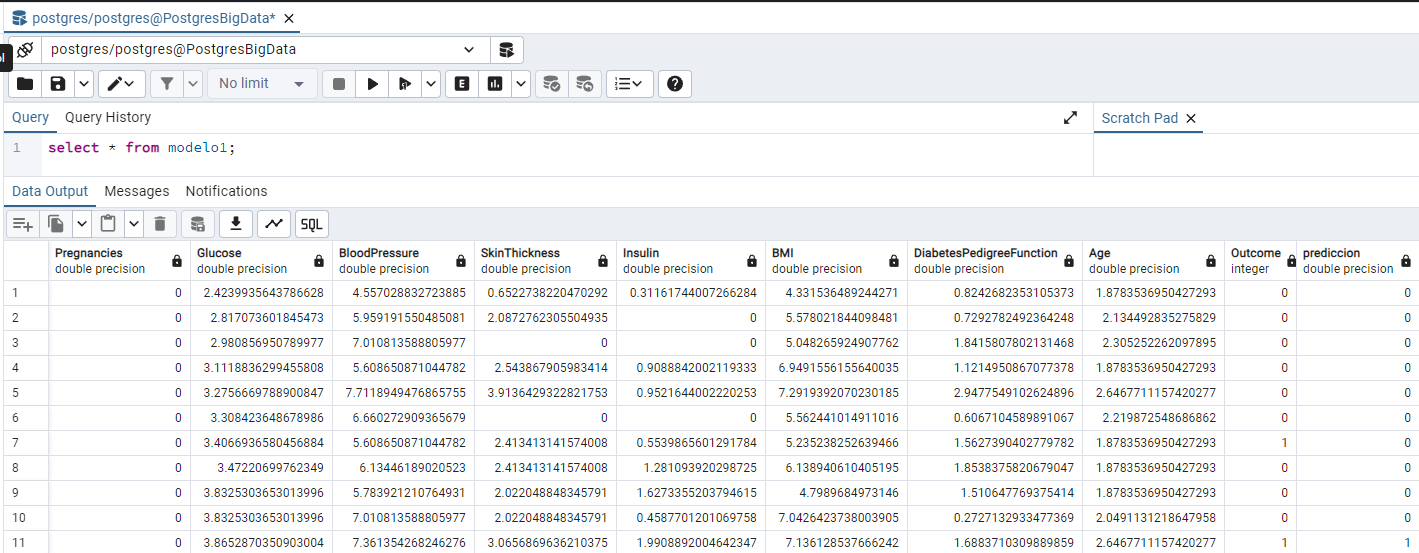

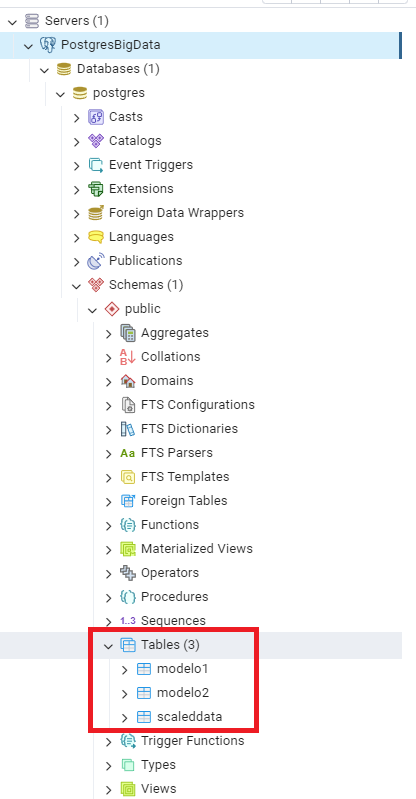